# Skincancer HAM-dataset using Pytorch

### Standardimporter

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torch.utils.data import WeightedRandomSampler

import os
from PIL import Image
# from skimage import io, transform

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Nedan används om man t.ex. vill ha tusentalsavgränsare:
import locale
locale.setlocale(locale.LC_ALL, '')

'LC_CTYPE=C.UTF-8;LC_NUMERIC=sv_SE.UTF-8;LC_TIME=sv_SE.UTF-8;LC_COLLATE=C.UTF-8;LC_MONETARY=sv_SE.UTF-8;LC_MESSAGES=C.UTF-8;LC_PAPER=sv_SE.UTF-8;LC_NAME=sv_SE.UTF-8;LC_ADDRESS=sv_SE.UTF-8;LC_TELEPHONE=sv_SE.UTF-8;LC_MEASUREMENT=sv_SE.UTF-8;LC_IDENTIFICATION=sv_SE.UTF-8'

## Hjälpfunktioner

In [3]:
def create_filename(filename):
    global file_name
    file_name = filename + "_e" + str(epochs) + "_bsz" + str(batchsz) + \
            "_lr" + str(f'{learning_rate:.0e}')
    return file_name

In [4]:
# https://pytorch.org/docs/master/notes/serialization.html

def save_trained_model(modelname):
    model_folder = "trained_models"
    model_file_suffix = ".pt"
    create_filename(modelname) # spottar ur sig ett filnamn i variabeln "file_name"
    
    full_model_filename = model_folder + "/" + file_name + model_file_suffix
    
    torch.save(mult_model.state_dict(), full_model_filename)

In [5]:
def load_trained_model(modelname):
    model_folder = "trained_models"
    model_file_suffix = ".pt"
    create_filename(modelname) # spottar ur sig ett filnamn i variabeln "file_name"
    
    full_model_filename = model_folder + "/" + file_name + model_file_suffix
    
    if torch.cuda.is_available():
        model.load_state_dict(torch.load(full_model_filename))
    else:
        model.load_state_dict(torch.load(full_model_filename, map_location=torch.device('cpu')))

In [6]:
# Följande återställer modellens vikter
# mellan körningar:

# usage: model.apply(weights_init)

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight.data)

## Importera data och definiera sökvägar

In [7]:
imageFolder = "../../../ml_datasets/skin-cancer-ham10k/images_in_one"

metadataSkincancerFilename =  "../../../ml_datasets/skin-cancer-ham10k/csv/HAM10000_metadata.csv"

In [8]:
# Importera metadatan i en Pandas DataFrame:

skincancer_df = pd.read_csv(metadataSkincancerFilename)

## Utforska och bearbeta vårt data

In [9]:
# Kolla om vi har några noll-värden i vår Dataframe:

skincancer_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [10]:
# Enligt ovan är det bara i "age"-kolumnen som vi har noll-värden. 
# Dessa fyller vi ut genom att beräkna medevärdet:

skincancer_df['age'].fillna((skincancer_df['age'].mean()), inplace=True)

In [11]:
# Definiera var vi har våra labels:

labels = skincancer_df['dx']
num_classes = len(labels.unique()) # --> 7

In [12]:
# Innan vi fortsätter måste vi göra om 
# text-datan till numeriska features.

# 1. Flytta labels sist i df
# 2. Flytta age till efter image_id
# 3. Alla categorical features emellan.

skincancer_df = skincancer_df[['lesion_id', 'image_id', 'age', 'dx_type', 'sex', 'localization', 'dx']]

In [13]:
dxtype_feat_df = skincancer_df.iloc[:, 3]
dxtype_feat_df.value_counts()

histo        5340
follow_up    3704
consensus     902
confocal       69
Name: dx_type, dtype: int64

In [14]:
sex_feat_df = skincancer_df.iloc[:, 4]
sex_feat_df.value_counts()

male       5406
female     4552
unknown      57
Name: sex, dtype: int64

In [15]:
loc_feat_df = skincancer_df.iloc[:, 5]
loc_feat_df.value_counts()

back               2192
lower extremity    2077
trunk              1404
upper extremity    1118
abdomen            1022
face                745
chest               407
foot                319
unknown             234
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: localization, dtype: int64

In [16]:
label_df = skincancer_df.iloc[:, 6]
label_df.value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

(array([  69.,    0.,    0.,  902.,    0.,    0., 3704.,    0.,    0.,
        5340.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

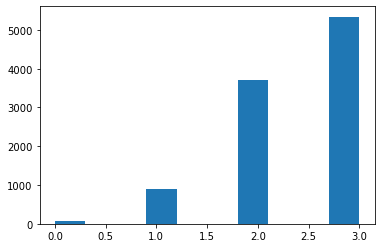

In [17]:
le = LabelEncoder()
dxtype_feat = le.fit_transform(dxtype_feat_df)
plt.hist(dxtype_feat)

(array([1029., 2192.,  463.,  745.,  319.,  138., 2077.,  296., 1404.,
        1352.]),
 array([ 0. ,  1.4,  2.8,  4.2,  5.6,  7. ,  8.4,  9.8, 11.2, 12.6, 14. ]),
 <BarContainer object of 10 artists>)

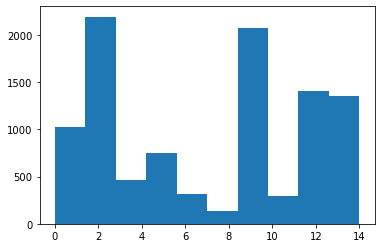

In [18]:
loc_feat = le.fit_transform(loc_feat_df)
plt.hist(loc_feat)

(array([4552.,    0.,    0.,    0.,    0., 5406.,    0.,    0.,    0.,
          57.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

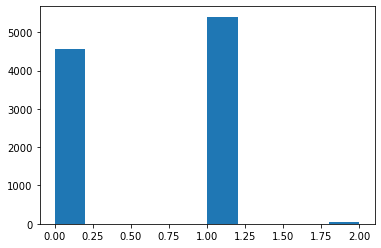

In [19]:
sex_feat = le.fit_transform(sex_feat_df)
plt.hist(sex_feat)

(array([ 327.,  514.,    0., 1099.,    0.,  115., 1113.,    0., 6705.,
         142.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

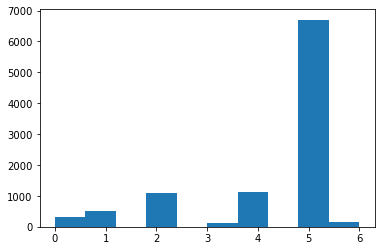

In [20]:
labels = le.fit_transform(label_df)
plt.hist(labels)

In [21]:
le_skincancer_df = skincancer_df.copy()
del skincancer_df

In [22]:
le_skincancer_df['dxtype'] = dxtype_feat
le_skincancer_df['sex'] = sex_feat
le_skincancer_df['loc'] = loc_feat
le_skincancer_df['label'] = labels
le_skincancer_df.drop(columns=['localization', 'dx_type', 'dx'], inplace = True)
le_skincancer_df.head()

,lesion_id,image_id,age,sex,dxtype,loc,label
0,HAM_0000118,ISIC_0027419,80.0,1,3,11,2
1,HAM_0000118,ISIC_0025030,80.0,1,3,11,2
2,HAM_0002730,ISIC_0026769,80.0,1,3,11,2
3,HAM_0002730,ISIC_0025661,80.0,1,3,11,2
4,HAM_0001466,ISIC_0031633,75.0,1,3,4,2


In [23]:
# Vi normaliserar metadata-features
# innan vi skickar in det till Pytorch 
# för träning:

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [24]:
le_skincancer_df[['age', 'dxtype', 'loc']] = scaler.fit_transform(le_skincancer_df[['age', 'dxtype', 'loc']])

In [25]:
le_skincancer_df.drop(columns='lesion_id', axis = 1, inplace=True)

In [26]:
le_skincancer_df.head(n = 5)

,image_id,age,sex,dxtype,loc,label
0,ISIC_0027419,0.941176,1,1.0,0.785714,2
1,ISIC_0025030,0.941176,1,1.0,0.785714,2
2,ISIC_0026769,0.941176,1,1.0,0.785714,2
3,ISIC_0025661,0.941176,1,1.0,0.785714,2
4,ISIC_0031633,0.882353,1,1.0,0.285714,2


In [27]:
features_df = le_skincancer_df.iloc[:, :5]

In [28]:
labels_df = le_skincancer_df.iloc[:, 5:]

## Bygg en egen dataloader-klass för bilder och Pandas-dataframe

In [29]:
class SkinCancerHamDF(Dataset):

    def __init__(self, features_df, labels_df, root_dir, transform = None):

        self.features_df = features_df
        self.labels_df = labels_df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.features_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.features_df.iloc[idx, 0]
        #print(type(img_name))
        img_name = str(img_name)
        #print(type(img_name))
        
        full_img_name_woext = os.path.join(self.root_dir, \
                                img_name)
        
        full_img_name = full_img_name_woext + ".jpg"
        
        # pillow:
        image = Image.open(full_img_name)
        
        # labels:
        label = self.labels_df.iloc[idx]
        label_np = np.array([label], dtype = int)
        
        # features:
        metadata = self.features_df.iloc[idx, 1:5]
        metadata_np = np.array([metadata], dtype = float)
        
        # Skapar en batch utan transforms:
        sample = {'image': image, \
                  'metadata': metadata_np, \
                  'label': label_np}

        # Skapar en batch med transforms:
        if self.transform:
            sample = {'image': self.transform(image), \
                      'metadata': metadata_np, \
                      'label': label_np.flatten()}

        return sample

In [30]:
# Definiera en batch-storlek:
batchsz = 2**5

# Definiera vilken augmentation som ska göras:
train_data_transform = transforms.Compose([
                                           transforms.Resize([224, 224]),\
                                           transforms.ToTensor(), 
                                           transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                                std = [0.229, 0.224, 0.225])
                                           ])

val_data_transform = transforms.Compose([
                                           transforms.Resize([224, 224]),\
                                           transforms.ToTensor(), \
                                           transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                                std = [0.229, 0.224, 0.225])
                                           ])

### Dela upp i tränings- och valideringsdata

In [31]:
features_train, features_val, labels_train, labels_val = train_test_split(features_df, \
                                                                          labels_df, \
                                                                          test_size = 0.1, \
                                                                          shuffle = True)

In [32]:
ham10k_train = SkinCancerHamDF(features_df = features_train, \
                               labels_df = labels_train, \
                               root_dir = imageFolder, \
                               transform = train_data_transform)

In [33]:
ham10k_val = SkinCancerHamDF(features_df = features_val, \
                             labels_df = labels_val, \
                             root_dir = imageFolder, \
                             transform = val_data_transform)

In [34]:
ham10k_train_dl = DataLoader(ham10k_train, \
                             batch_size = batchsz, \
                             num_workers = 4, \
                             pin_memory = True, \
                             )

In [35]:
ham10k_val_dl = DataLoader(ham10k_val, \
                           batch_size = batchsz, \
                           pin_memory = True, \
                           num_workers = 4, \
                            )

In [36]:
# Flytta till grafikkortet:

use_cuda = torch.cuda.is_available() # True/False
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

# Override:
# device = "cpu"

cuda:0


## Importera en Alexnet-modell

In [37]:
# W_out = (W_in - Kernel_Filtersz + 2*padding) / stride + 1
# Avrundas neråt.

metadata_input_dim = features_df.shape[1] -1 # första kolumnen är bildnamnet...

In [38]:
model = models.AlexNet(num_classes = num_classes)

In [39]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [40]:
# Hämta en batch för att skicka igenom
# ett nätverk:

for x in ham10k_train_dl:
    x = x['image']
    print("Ursprunglig storlek: ", x.shape)
    break

Ursprunglig storlek:  torch.Size([32, 3, 224, 224])


In [41]:
x_0 = x

In [42]:
x_1 = model.features(x_0)

In [43]:
x_2 = model.avgpool(x_1)

In [44]:
x_2.shape

torch.Size([32, 256, 6, 6])

In [45]:
model = models.AlexNet(7)

In [46]:
model.modules

<bound method Module.modules of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216,

In [47]:
class MultInput(nn.Module):
    def __init__(self):
        super(MultInput, self).__init__()
        
        #model = models.AlexNet(num_classes = 7)
        
        self.alexnet = models.AlexNet(num_classes = 7)
        #self.
        
        
        self.fcc = nn.Sequential(
            nn.Linear(6*6*256 + metadata_input_dim, 512),
            nn.Linear(512, 256),
            nn.Linear(256, 64),
            nn.Dropout(p = 0.3),
            nn.Linear(64, num_classes),
            )
        
    def forward(self, x1, x2):
        x1 = self.alexnet.features(x1)
        x1 = self.alexnet.avgpool(x1)
        
        x1 = x1.view(x1.size(0), -1)
        x2 = x2.view(x2.size(0), -1)
        
        x = torch.cat((x1, x2), dim = 1)
        x = self.fcc(x)

        return x        

In [48]:
# Definiera en instans av CNN():
mult_model = MultInput()

# Flytta till rätt device för träning:
mult_model.to(device)

MultInput(
  (alexnet): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
     

In [49]:
# Dubbelkolla att modellen flyttats till 
# grafikkortet eller ej (True/False):

next(mult_model.parameters()).is_cuda

True

In [50]:
# Hur många parametrar har modellen
# att träna?

trainableparameters = []
for param in mult_model.parameters():
    # trainableparameters = param.numel()
    trainableparameters.append(param.numel())

tot_params = np.sum(trainableparameters)

print(f'Antalet träningsbara parametrar är {tot_params:n} st')

Antalet träningsbara parametrar är 61 901 902 st


### Återställ nätets vikter

In [51]:
mult_model.apply(weights_init)

MultInput(
  (alexnet): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
     

### Loss och optimiser

In [52]:
# Definiera loss-function och vilken optimerare som ska användas:

epochs = 10 # verkar räcka med tanke på overfitting.

learning_rate = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mult_model.parameters(), lr = learning_rate)

In [53]:
modelname = create_filename("multi_model_cnn")
print(modelname)

multi_model_cnn_e10_bsz32_lr1e-04


## Trainingloop:

In [54]:
mult_model.apply(weights_init)

do_validation = 1

import time
start_training_time = time.time()

num_training_images = len(ham10k_train_dl.dataset)
num_val_images = len(ham10k_val_dl.dataset)

accuracy_train = []
losses_train = []
accuracy_val = []
losses_val = []

for epoch in range(epochs):
    start_epoch_time = time.time()
    
    num_correct_per_epoch_train = 0
    tot_loss_per_epoch_train = 0.0
 
    for idx_train, inputs_train in enumerate(ham10k_train_dl):
        images_train = inputs_train['image'].float().to(device)
        metadata_train = inputs_train['metadata'].float().to(device)
        labels_train = inputs_train['label'].flatten().to(device)
        
        mult_model.train()
        # Låt modellen göra förutsägelser:
        predictions_train = mult_model.forward(images_train, metadata_train)
        
        # Beräkna statistik från träningen på träningsmängden:
        _, predicted_train = torch.max(predictions_train.data, 1)
        num_correct_per_batch_train = torch.sum(predicted_train.detach() == labels_train.detach())
        num_correct_per_epoch_train += num_correct_per_batch_train
        
        # Beräkna loss:
        loss_per_batch_train = criterion(predictions_train, labels_train)
        tot_loss_per_epoch_train += loss_per_batch_train.item() * batchsz
        
        # Nolla ackadumulerade gradienter, göra 
        # backprop. & uppdatera vår optimeringsfunktion:
        optimizer.zero_grad()
        loss_per_batch_train.backward()
        optimizer.step()
        
    # Validation
    if do_validation == True:
        start_eval_time = time.time()
        mult_model.eval()
        
        num_correct_per_epoch_val = 0
        tot_loss_per_epoch_val = 0.0
        
        for idx_val, inputs_val in enumerate(ham10k_val_dl):
            images_val = inputs_val['image'].float().to(device)
            metadata_val = inputs_val['metadata'].float().to(device)
            labels_val = inputs_val['label'].flatten().to(device)

            with torch.no_grad():
                            
                predictions_val = mult_model.forward(images_val, metadata_val)
                _, predicted_val = torch.max(predictions_val, 1)
                # Behöver ej använda .detach med torch.no_grad()
                num_correct_per_batch_val = torch.sum(predicted_val == labels_val)
                #num_correct_per_batch_val = torch.sum(predicted_val.detach() == labels_val.detach())
                num_correct_per_epoch_val += num_correct_per_batch_val
                
                loss_per_batch_val = criterion(predictions_val, labels_val) 
                tot_loss_per_epoch_val += loss_per_batch_val.item() * batchsz
        
        end_eval_time = time.time()
    else:
        pass
    
    # Beräkna statistik från epoken:
    # Use torch.Tensor.item() to get a Python number 
    # from a tensor containing a single value:
    
    # acc, train:
    accuracy_per_epoch_train = num_correct_per_epoch_train.item() / num_training_images
    accuracy_train.append(accuracy_per_epoch_train)
        
    # loss, train:
    loss_per_epoch_train = tot_loss_per_epoch_train / num_training_images
    losses_train.append(loss_per_epoch_train)
    
    if do_validation == True:
        # acc, val:
        accuracy_per_epoch_val = num_correct_per_epoch_val.item() / num_val_images
        accuracy_val.append(accuracy_per_epoch_val)
        
        # loss, val:
        loss_per_epoch_val = tot_loss_per_epoch_val / num_val_images
        losses_val.append(loss_per_epoch_val)
    else:
        pass
    
    end_epoch_time = time.time()
    epoch_time = end_epoch_time - start_epoch_time
    
    # epoch startar på 0, därav "+1" nedan:
    if do_validation == True:
        print(f"Epok {epoch+1:03}, {epoch_time:4.1f} sek. --- train acc = {accuracy_per_epoch_train:4.3f} --- val acc = {accuracy_per_epoch_val:4.3f} --- train loss = {loss_per_epoch_train:4.5f} --- val loss = {loss_per_epoch_val:4.5f}")
    else:
        print(f"Epok {epoch+1:03}, {epoch_time:4.1f} sek. --- train acc = {accuracy_per_epoch_train:4.3f} --- train loss = {loss_per_epoch_train:4.5f}")
    
end_training_time = time.time()

delta = end_training_time - start_training_time

print(f'\nTraining took {delta/60:.2f} minutes.')    

Epok 001, 35.8 sek. --- train acc = 0.670 --- val acc = 0.672 --- train loss = 0.97184 --- val loss = 0.88242
Epok 002, 35.3 sek. --- train acc = 0.694 --- val acc = 0.697 --- train loss = 0.86127 --- val loss = 0.80404
Epok 003, 35.2 sek. --- train acc = 0.703 --- val acc = 0.704 --- train loss = 0.81824 --- val loss = 0.78655
Epok 004, 35.4 sek. --- train acc = 0.721 --- val acc = 0.729 --- train loss = 0.76076 --- val loss = 0.73446
Epok 005, 35.4 sek. --- train acc = 0.736 --- val acc = 0.751 --- train loss = 0.71755 --- val loss = 0.70865
Epok 006, 35.2 sek. --- train acc = 0.756 --- val acc = 0.750 --- train loss = 0.66967 --- val loss = 0.67937
Epok 007, 35.2 sek. --- train acc = 0.768 --- val acc = 0.751 --- train loss = 0.62765 --- val loss = 0.64721
Epok 008, 35.5 sek. --- train acc = 0.787 --- val acc = 0.763 --- train loss = 0.58090 --- val loss = 0.65243
Epok 009, 35.5 sek. --- train acc = 0.804 --- val acc = 0.759 --- train loss = 0.52979 --- val loss = 0.66239
Epok 010, 

In [55]:
save_trained_model(modelname)

## Visualisering av träningsomgången

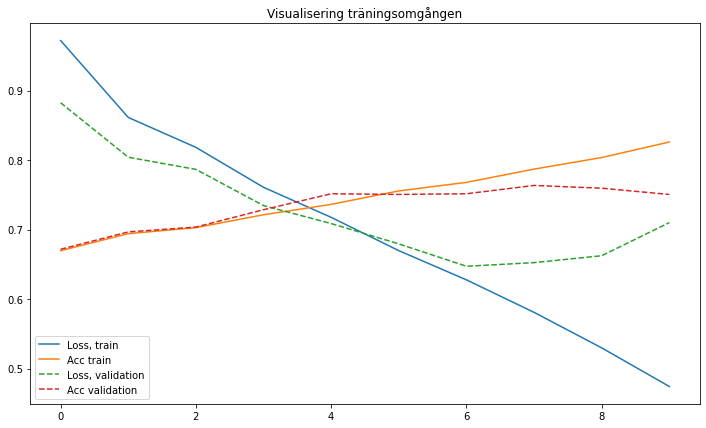

In [62]:
if do_validation == False:

    plt.figure(figsize = (12, 7))
    plt.title("Visualisering träningsomgången")
    plt.plot(losses_train, label = "Loss")
    plt.plot(accuracy_train, label = "Andel korrekta")
    plt.legend()
    plt.show()
else:
    plt.figure(figsize = (12, 7))
    plt.title("Visualisering träningsomgången")
    plt.plot(losses_train, label = "Loss, train")
    plt.plot(accuracy_train, label = "Acc train")
    plt.plot(losses_val, label = "Loss, validation", linestyle='dashed')
    plt.plot(accuracy_val, label = "Acc validation", linestyle='dashed')
    plt.legend(loc = 'lower left')
    plt.show()

## Utvärdering

In [57]:
def evaluate_model(num_eval_images, data_generator, model):

    model.eval()

    start_eval_test_time = time.time()
    
    global labels_val_true_np, predicted_val_np
    
    labels_ground_truth = []
    predicted_classes_val = []
    
    with torch.no_grad():
        correct_val = 0
        # Antal iterationer = num_images / batchsz = x st.
        for inputs in data_generator:
            images = inputs['image'].float().to(device)
            metadata = inputs['metadata'].float().to(device)
            labels = inputs['label'].flatten().to(device)
            
            # Spara för mer utvärdering utanför denna funktion:
            labels_ground_truth.append(labels.cpu().numpy())
        
            # Låt modellen göra förutsägelser:
            predictions_val = mult_model.forward(images, metadata)
            _, predicted_val = torch.max(input = predictions_val, dim = 1)
            predicted_classes_val.append(predicted_val.cpu().numpy())
            
            correct_val += (predicted_val == labels).sum()

        # Platta till listorna...
        labels_ground_truth = [item for sublist in labels_ground_truth for item in sublist]
        predicted_classes_val = [item for sublist in predicted_classes_val for item in sublist]
        
        #flat_list = []
        #for sublist in predicted_classes_val:
        #    for item in sublist:
        #        flat_list.append(item)
        
        labels_val_true_np = np.array(labels_ground_truth)
        predicted_val_np = np.array(predicted_classes_val)        
        
        end_eval_test_time = time.time()
        eval_test_time = end_eval_test_time - start_eval_test_time

    print(f'Test accuracy: {correct_val.item()}/{num_eval_images} = {100*correct_val.item()/(num_eval_images):5.2f} %')
    print(f"\nEvaluation took {eval_test_time:.2f} seconds.")

In [58]:
evaluate_model(len(ham10k_val_dl.dataset), ham10k_val_dl, mult_model)

Test accuracy: 752/1002 = 75.05 %

Evaluation took 3.69 seconds.


In [59]:
cm_pytorch = confusion_matrix(labels_val_true_np, predicted_val_np)

In [60]:
print(cm_pytorch)

[[ 10   8   2   0   2   4   0]
 [  4  36   3   0   1   5   4]
 [  3   7  40   0  22  47   0]
 [  1   4   1   0   0   3   2]
 [  6   4   4   0  55  38   3]
 [  0   4   6   0  54 596   6]
 [  0   0   0   0   2   0  15]]


In [61]:
print(classification_report(labels_val_true_np, predicted_val_np))

precision    recall  f1-score   support

           0       0.42      0.38      0.40        26
           1       0.57      0.68      0.62        53
           2       0.71      0.34      0.46       119
           3       0.00      0.00      0.00        11
           4       0.40      0.50      0.45       110
           5       0.86      0.89      0.88       666
           6       0.50      0.88      0.64        17

    accuracy                           0.75      1002
   macro avg       0.50      0.53      0.49      1002
weighted avg       0.75      0.75      0.74      1002



/home/johan/anaconda3/envs/pytorch_general/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
